# DengAI - Predicting Disease Spread

This project is a challenge from [Driven Data](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/80/).

The current status: **Ongoing...**

## Overview

### Can you predict local epidemics of dengue fever?

Dengue fever is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In mild cases, symptoms are similar to the flu: fever, rash, and muscle and joint pain. In severe cases, dengue fever can cause severe bleeding, low blood pressure, and even death.

Because mosquitoes carry it, the transmission dynamics of dengue are related to climate variables such as temperature and precipitation. Although the relationship to climate is complex, a growing number of scientists argue that climate change is likely to produce distributional shifts that will have significant public health implications worldwide.

Using environmental data collected by various U.S. Federal Government agencies—from the Centers for Disease Control and Prevention to the National Oceanic and Atmospheric Administration in the U.S. Department of Commerce— *can you predict the number of dengue fever cases reported each week in San Juan, Puerto Rico and Iquitos, Peru?*

### Goal

The project's goal is to predict the **total_cases** label for each (**city, year, weekofyear**) in the test set. There are two cities, San Juan and Iquitos, with test data for each city spanning 5 and 3 years respectively. You will make one submission that contains predictions for both cities. The data for each city were concatenated along with a city column indicating the source: **sj** for San Juan and **iq** for Iquitos. The test set is a real future hold-out, meaning the test data are sequential and non-overlapping with any of the training data. Throughout, missing values have were filled as *NaNs*.

## Features description

The description of every feature is following:
### City and date indicators
- **city** – City abbreviations: sj for San Juan and iq for Iquitos
- **week_start_date** – Date given in yyyy-mm-dd format

### NOAA's GHCN daily climate data weather station measurements
- **station_max_temp_c** – Maximum temperature
- **station_min_temp_c** – Minimum temperature
- **station_avg_temp_c** – Average temperature
- **station_precip_mm** – Total precipitation
- **station_diur_temp_rng_c** – Diurnal temperature range

### PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)
- **precipitation_amt_mm** – Total precipitation

### NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)
- **reanalysis_sat_precip_amt_mm** – Total precipitation
- **reanalysis_dew_point_temp_k** – Mean dew point temperature
- **reanalysis_air_temp_k** – Mean air temperature
- **reanalysis_relative_humidity_percent** – Mean relative humidity
- **reanalysis_specific_humidity_g_per_kg** – Mean specific humidity
- **reanalysis_precip_amt_kg_per_m2** – Total precipitation
- **reanalysis_max_air_temp_k** – Maximum air temperature
- **reanalysis_min_air_temp_k** – Minimum air temperature
- **reanalysis_avg_temp_k** – Average air temperature
- **reanalysis_tdtr_k** – Diurnal temperature range

### Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements
- **ndvi_se** – Pixel southeast of city centroid
- **ndvi_sw** – Pixel southwest of city centroid
- **ndvi_ne** – Pixel northeast of city centroid
- **ndvi_nw** – Pixel northwest of city centroid

## Understanding the problem and the features

Before any other step, it's essential to understand the disease and the given features, and then we can get insights from it.

### What is Dengue and how is it proliferated?

Dengue is a mosquito-transmitted disease. The mosquito Aedes aegypti, a primary vector of dengue, yellow fever, and chikungunya viruses, is widely distributed in the **subtropics and tropics** [[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3516267/). According to WHO (*World Health Organization*), **climate change may affect transmission**, as dengue mosquitoes reproduce more quickly and bite more frequently at **higher temperatures** [[2]](https://www.who.int/heli/risks/vectors/denguecontrol/en/). Also, in proximity to human settlements, Aedes aegypti mosquitoes breed primarily in **artificial water containers**, and the mosquito’s life-cycle is closely associated with **human activities**. Larval habitats are increasing rapidly in **urban areas**.

The temperature variations and **rainfall intensity** affect the reproductive cycle and survival of the vector, which causes changes in its distribution and density since mosquitoes need **humidity** and temperatures ranging between **15°C and 35°C** to survive and reproduce [[3]](http://www.scielo.br/pdf/ramb/v63n11/0104-4230-ramb-63-11-0957.pdf). Rainfall provides plenty of breeding sites for mosquito vectors such as puddles, while humidity affects the adult mosquitoes’ survival and **biting frequency** [[4]](https://bmcpublichealth.biomedcentral.com/articles/10.1186/s12889-018-5532-4). Finally, there is a **negative correlation** between the Diurnal Temperature Range (**DTR**) and dengue incident [[5]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5002035/).

### Features explained

The driven features in the dataset are **city**, **year**, **weekofyear**. Also, **week_start_date** can be helpful to understand trends and patterns in data.

Some explanatory variables are very intuitive. The precipitation features represent the amount (in mm) of water downfall on that current week (**station_precip_mm**, **precipitation_amt_mm**, **reanalysis_sat_precip_amt_mm**, **reanalysis_precip_amt_kg_per_m2**). The same precipitation information is given from different sources and different scales.

The temperature features represent the weekly climate conditions. This information is given in a tricky way. For example, **station_max_temp_c** is the weekly maximum temperature average, and **station_min_temp_c** weekly minimum average. But **station_avg_temp_c**, which is the average temperature, is not the mean between the weekly maximum average and minimum average, but the mean of the daily average from that week. The same goes for air temperature features (**reanalysis_air_temp_k**, **reanalysis_max_air_temp_k**, **reanalysis_min_air_temp_k**, **reanalysis_avg_temp_k**). It's important to notice that some temperature features are expressed in **Kelvin** and others in **Celsius**.

The humidity is measured in several ways in this dataset. There is a Dew Point temperature (**eanalysis_dew_point_temp_k**), relative humidity (**reanalysis_relative_humidity_percent**) and specific humidity (**reanalysis_specific_humidity_g_per_kg**). Some studies confirm that dew point and humidity have a nearly linear relationship [[6]](https://journals.ametsoc.org/doi/10.1175/BAMS-86-2-225). It is possible to measure the humidity percentage using the dew point and air temperature [[7]](http://www.reahvac.com/tools/humidity-formulas/).

Finally, the **NDVI** is a measure of how much green vegetation presents at a determined location. [[8]](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/). This number ranges from -1 (none or less green) to +1 (very green).

We can note that a series of factors may cause dengue occurrence:
- High temperatures
- Rainfall intensity
- Humidity
- Urban areas and human proximity

Doing a quick recap on the features we have, we can group them related to the possible dengue spread causes.

|	     Temperature	  |	           Rain             |               Humidity              | Urbanization |
|-------------------------|-----------------------------|-------------------------------------|--------------|
|    station_max_temp_c   |   station_precip_mm         |    reanalysis_dew_point_temp_k      |   ndvi_se    |
|    station_min_temp_c   |   precipitation_amt_mm      |reanalysis_relative_humidity_percent |   ndvi_sw    |
|    station_avg_temp_c   |reanalysis_sat_precip_amt_mm |reanalysis_specific_humidity_g_per_kg|   ndvi_ne    |
| station_diur_temp_rng_c |reanalysis_precip_amt_kg_per_m2|        reanalysis_air_temp_k        |   ndvi_nw    |
|    reanalysis_tdtr_k    |             -               |      reanalysis_max_air_temp_k      |      -       |
|   reanalysis_avg_temp_k |             -               |      reanalysis_min_air_temp_k      |      -       |


Important to remember: the target variable is **'total_cases'**. We have to predict the number of cases in **two different cities**. In a given moment, we will separate the data into two dataframes and observing the behavior separately.

## Importing data

Let's begin the data manipulation based on what we learned so far.

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

The data is separated into two datasets: features_train and labels.

In [2]:
df_features_train = pd.read_csv('data/dengue_features_train.csv')
df_labels_train = pd.read_csv('data/dengue_labels_train.csv')

In [3]:
df_features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [4]:
df_labels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
city           1456 non-null object
year           1456 non-null int64
weekofyear     1456 non-null int64
total_cases    1456 non-null int64
dtypes: int64(3), object(1)
memory usage: 45.6+ KB


We can observe that the labels contain the **dependent variable**, our target, **total_cases**. To facilitate data manipulation, let's put all data into a single *dataframe*.

In [5]:
df_train = pd.merge(df_features_train, df_labels_train, how='left', left_on=['city','year','weekofyear'], right_on=['city','year','weekofyear']) 


In [6]:
df_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


### Treating missing values

The first thing to do with the data is to check missing values. We can use a missingno library to visualize the missing value relevance before treating data.

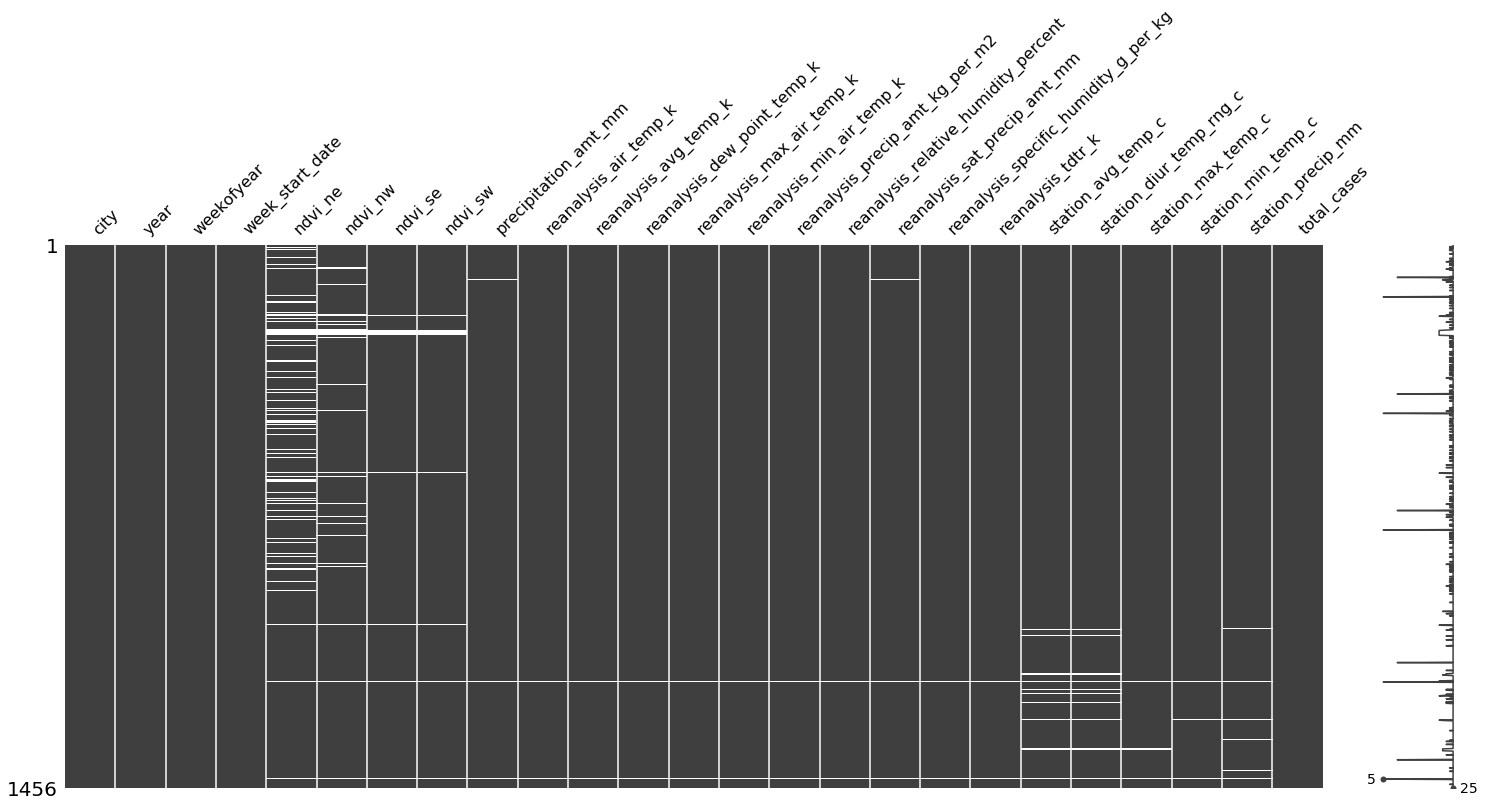

In [7]:
msno.matrix(df_train);

It is apparent some missing values in this dataset, represented by the yellow color in the heatmap. Some data are *entirely missing*, except for the labels. Also is notable the missing values in the **NDVI** features, some **temperature** features from NOAA's GHCN source, and some in the **precipitation** features.

There are some ways to overcome this issue.

#### Precipitation features

This dataset contains three precipitation amount features representing similar the same information but from different sources. Let's see how similar those features are.

In [9]:
cols_precipitation = ['station_precip_mm', 'precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm', 'reanalysis_precip_amt_kg_per_m2']

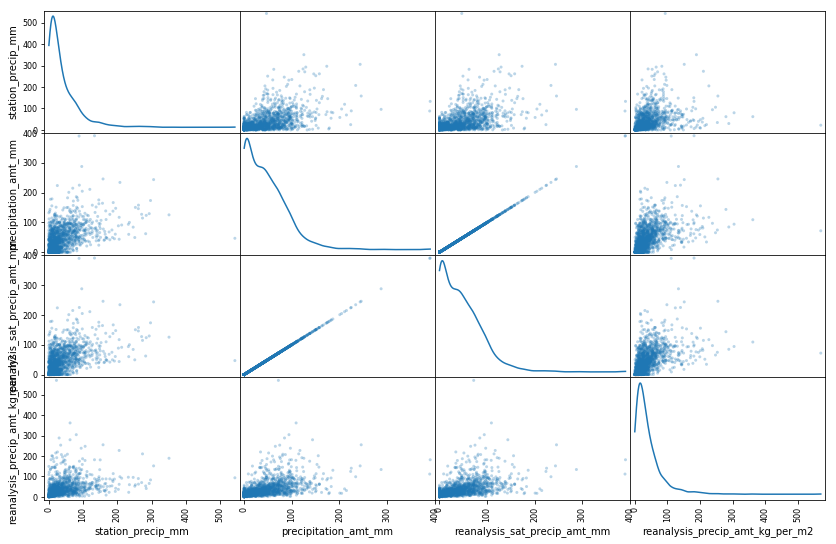

In [10]:
pd.plotting.scatter_matrix(df_train[cols_precipitation], alpha = 0.3, figsize = (14,9), diagonal = 'kde');

There is *multicollinearity* between the **precipitation_amt_mm**, **reanalysis_sat_precip_amt_mm** features. Also, we can observe that the **station_precip_mm** and **reanalysis_precip_amt_kg_per_m2** features don't present a linear relation with the other elements. This situation is *plausible* since those features were generated with different techniques and from different sources.
> Precipitation measured in kg_per_m2 and mm are equivalent.

In [11]:
#Filtering just missing values from precipitation_amt_mm and reanalysis_sat_precip_amt_mm, where exist value on station_precip_mm column
df_train[cols_precipitation][~df_train['station_precip_mm'].isnull() & (df_train['precipitation_amt_mm'].isnull() | df_train['reanalysis_sat_precip_amt_mm'].isnull())]


,station_precip_mm,precipitation_amt_mm,reanalysis_sat_precip_amt_mm,reanalysis_precip_amt_kg_per_m2
93,1.3,NaN,NaN,20.1
94,8.9,NaN,NaN,4.4
95,16.0,NaN,NaN,14.4


Observe that all missing values from **precipitation_amt_mm** are presented in the column **reanalysis_sat_precip_amt_mm**. So, it is safe to *remove any* of those two features. The **reanalysis_sat_precip_amt_mm** will be removed later, in the appropriate moment.

Notice that some missing values from those two features are presented on **station_precip_mm**. It is possible to fulfill those missing values just copying from the **station_precip_mm** or **reanalysis_precip_amt_kg_per_m2** features. The inverse is also possible. It is also possible to use the mean between the other features to fulfill those values.

In [12]:
cols_precipitation = ['station_precip_mm', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2']

In [13]:
#Showing just the number of missing values from station_precip_mm that contains value on precipitation_amt_mm or reanalysis_precip_amt_kg_per_m2
df_train[cols_precipitation][(~df_train['precipitation_amt_mm'].isnull() | ~df_train['reanalysis_precip_amt_kg_per_m2'].isnull()) & df_train['station_precip_mm'].isnull()].shape                            


(12, 3)

In [14]:
#Checking one of the NaN features
df_train[cols_precipitation].iloc[[94]]

,station_precip_mm,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2
94,8.9,NaN,4.4


In [15]:
def fill_nan_average(row, cols):
    return row[cols].mean()

In [16]:
#fill NaN values of precipitation_amt_mm
df_train['precipitation_amt_mm'] = df_train.apply(lambda row: 
                                               fill_nan_average(row, ['station_precip_mm', 'reanalysis_precip_amt_kg_per_m2']) 
                                               if np.isnan(row['precipitation_amt_mm']) & (~np.isnan(row['station_precip_mm']) | ~np.isnan(row['reanalysis_precip_amt_kg_per_m2']))
                                               else row['precipitation_amt_mm'], axis=1)


In [17]:
#Checking one of the NaN again, to see the change
df_train[cols_precipitation].iloc[[94]]

,station_precip_mm,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2
94,8.9,6.65,4.4


In [18]:
#Let's fill the others precipitation features
df_train['station_precip_mm'] = df_train.apply(lambda row: 
                                               fill_nan_average(row, ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2']) 
                                               if np.isnan(row['station_precip_mm']) & (~np.isnan(row['precipitation_amt_mm']) | ~np.isnan(row['reanalysis_precip_amt_kg_per_m2']))
                                               else row['station_precip_mm'], axis=1)
df_train['reanalysis_precip_amt_kg_per_m2'] = df_train.apply(lambda row: 
                                               fill_nan_average(row, ['station_precip_mm', 'precipitation_amt_mm']) 
                                               if np.isnan(row['reanalysis_precip_amt_kg_per_m2']) & (~np.isnan(row['station_precip_mm']) | ~np.isnan(row['precipitation_amt_mm']))
                                               else row['reanalysis_precip_amt_kg_per_m2'], axis=1)

#### NDVI features

The NDVI features represent the vegetation around the city corners. Instead of using those features separated, we can derivate them, conserving the relevance and reducing dimensionality. For example, we can remove the four corners features and substitute for a *mean* value.

In [19]:
cols_ndvi = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']

In [20]:
def ndvi_mean(row):
    return row[cols_ndvi].mean()

In [21]:
#Creating new features
df_train['ndvi_mean'] = df_train.apply(lambda row: ndvi_mean(row), axis=1)

In [22]:
#Removing the old NDVI features
df_train.drop(cols_ndvi, axis=1, inplace=True)

In [23]:
cols_ndvi = ['ndvi_mean']

#### Temperature features

Before check any temperature feature, even the ones regard humidity; it is notable that some features present *Kelvin* unit. Normalizing to a single measure is necessary. I will foster *Celsius* as the standard unit.
> The only exception is the **reanalysis_tdtr_k** feature since diurnal temperature is independent of the unit.

In [24]:
def convertKelvinToCelsius(k):
    return k - 273.15

In [25]:
cols_kelvin = ['reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_air_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k']


In [26]:
#Creating new Celsius features
df_train['reanalysis_avg_temp_c'] = df_train.apply(lambda row: convertKelvinToCelsius(row['reanalysis_avg_temp_k']), axis=1)
df_train['reanalysis_dew_point_temp_c'] = df_train.apply(lambda row: convertKelvinToCelsius(row['reanalysis_dew_point_temp_k']), axis=1)
df_train['reanalysis_air_temp_c'] = df_train.apply(lambda row: convertKelvinToCelsius(row['reanalysis_air_temp_k']), axis=1)
df_train['reanalysis_max_air_temp_c'] = df_train.apply(lambda row: convertKelvinToCelsius(row['reanalysis_max_air_temp_k']), axis=1)
df_train['reanalysis_min_air_temp_c'] = df_train.apply(lambda row: convertKelvinToCelsius(row['reanalysis_min_air_temp_k']), axis=1)


In [27]:
#Removing Kelvin features
df_train.drop(cols_kelvin, axis=1, inplace=True)

In [28]:
cols_temperature = ['station_max_temp_c', 'station_min_temp_c', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'reanalysis_tdtr_k', 'reanalysis_avg_temp_c']

Let's check the missing values of the temperature features again. Then, we review the correlation.

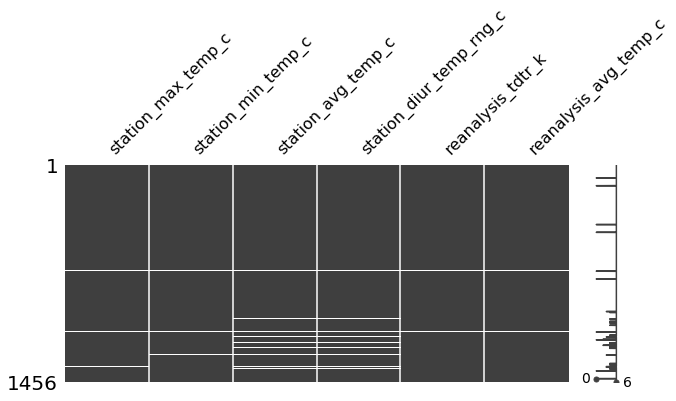

In [29]:
msno.matrix(df_train[cols_temperature], figsize=(10,4));

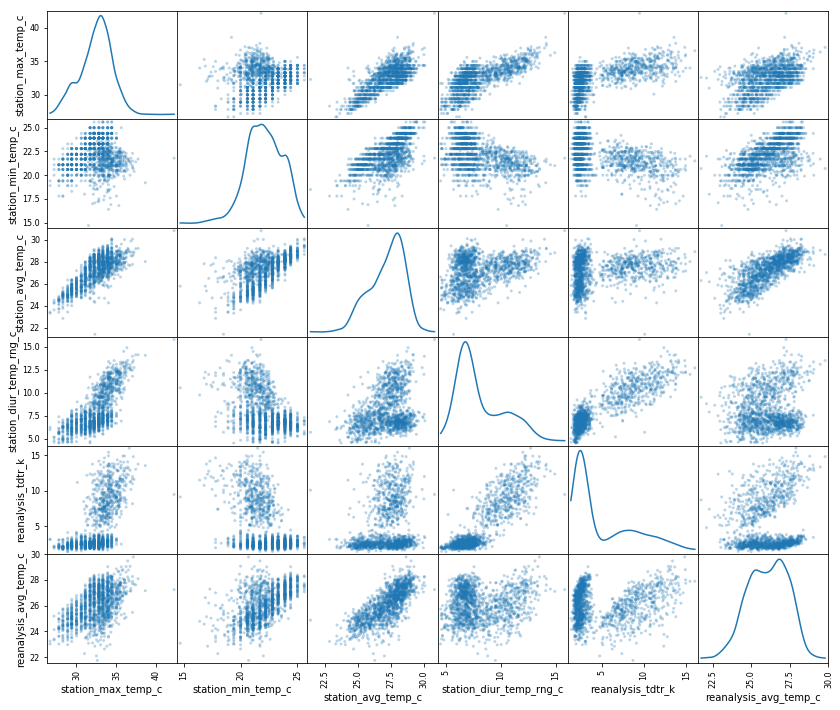

In [30]:
pd.plotting.scatter_matrix(df_train[cols_temperature], alpha = 0.3, figsize = (14,12), diagonal = 'kde');

It's notable that there is a high linear correlation between the **station_avg_temp_c** and **reanalysis_avg_temp_c**. Also, the **station_avg_temp_c** contains some missing values. So, it is *safe* to use the **reanalysis_avg_temp_c** to fulfill the missing values from **station_avg_temp_c**. The same applies between the **station_diur_temp_rng_c** and **reanalysis_tdtr_k**.

In [31]:
df_train['station_avg_temp_c'] = df_train.apply(lambda row: 
                                               row['reanalysis_avg_temp_c'] if np.isnan(row['station_avg_temp_c'])
                                               else row['station_avg_temp_c'], axis=1)
df_train['station_diur_temp_rng_c'] = df_train.apply(lambda row: 
                                               row['reanalysis_tdtr_k'] if np.isnan(row['station_diur_temp_rng_c'])
                                               else row['station_diur_temp_rng_c'], axis=1)

> For now, we do not fulfill the min and max temperature feature with missing values

#### The other features

Let's check now how the dataset is after those fulfilling and creating features.

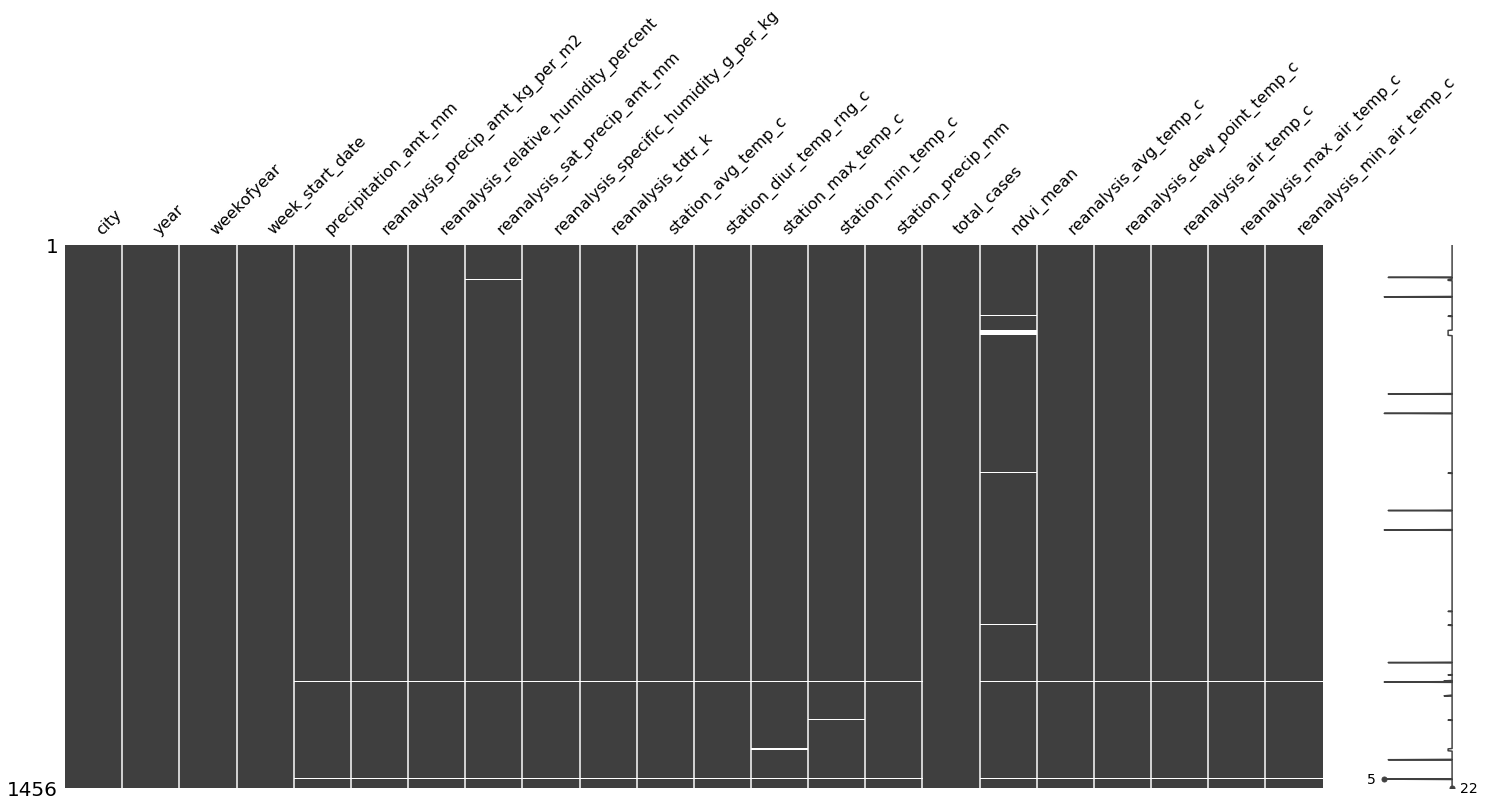

In [32]:
msno.matrix(df_train);

We can see that we still have some features to fulfill. Those columns are *harder* to work with because they don't have dependency with others. However, we have a dataset with an advantage: a **time line**.

With this powerful resource, we can **interpolate** the missing values, to remove NaN values.

#### Interpolating missing values

Before starting the interpolation, we have to remember: there are two different cities. That means, there are two different *timelines*. So, to interpolate values, we should first split the dataset in two.

In [33]:
#Creating week_start_date as index
df_train['week_start_date'] = pd.to_datetime(df_train['week_start_date'], format='%Y-%m-%d')
df_train.set_index('week_start_date', inplace=True)
#sorting index
df_train.sort_index(inplace=True)

In [34]:
#Checking the cities values
df_train.city.unique()

array(['sj', 'iq'], dtype=object)

In [35]:
df_train_sj = df_train[df_train['city'] == 'sj']
df_train_iq = df_train[df_train['city'] == 'iq']
#Dropping city column
df_train_sj = df_train_sj.drop(['city'], axis=1)
df_train_iq = df_train_iq.drop(['city'], axis=1)

To interpolate values to fulfill NaN, we use interpolate() from pandas. First, we have to index and sort the dataset, using the **week_start_date** feature.

To be more clear, look at a previous known missing value and their neighbors in the **sj** dataframe.

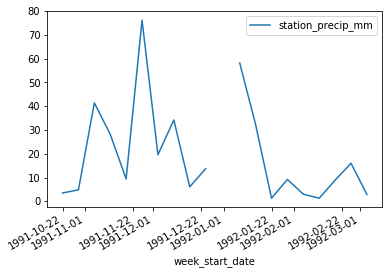

In [37]:
df_train_sj[['station_precip_mm']].iloc[77:97].plot();

There is a missing value in this example. With the interpolating method, we can find a value between all missing values from this dataset.

In [39]:
df_train_sj_inter = df_train_sj.interpolate()
df_train_iq_inter = df_train_iq.interpolate()

With the new dataframe, with interpolated values, it is possible to check the fulfilled values.

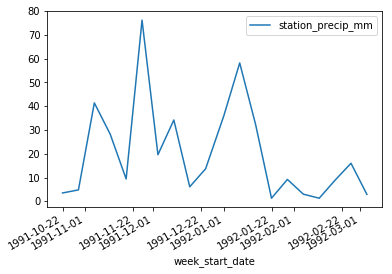

In [40]:
df_train_sj_inter[['station_precip_mm']].iloc[77:97].plot();

So, all missing values are fulfilled, without lose much information.

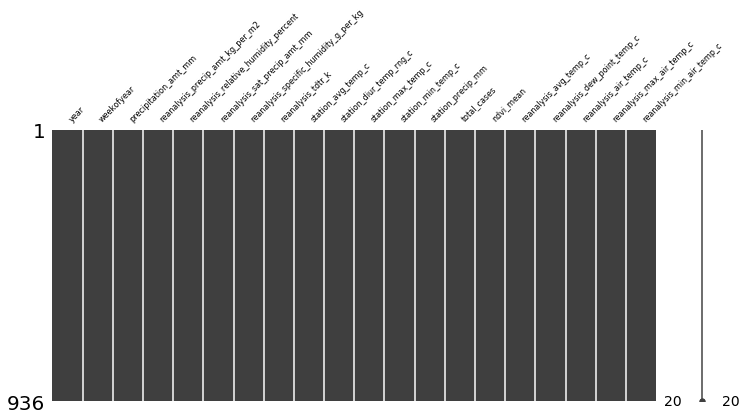

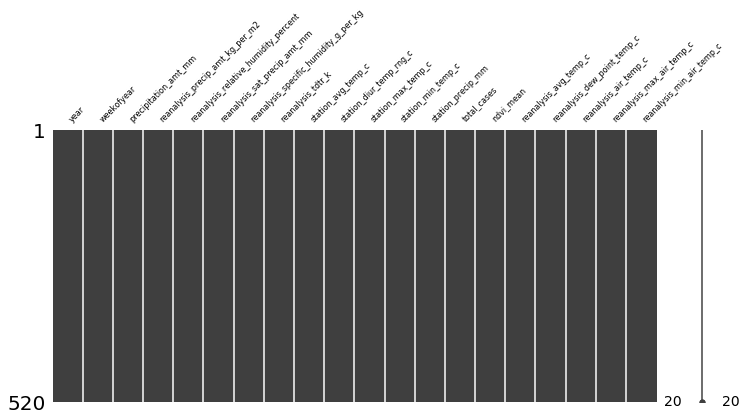

In [41]:
msno.matrix(df_train_sj_inter, figsize=(12, 5), fontsize=8)
msno.matrix(df_train_iq_inter, figsize=(12, 5), fontsize=8);

### Treating date/season related features

The dataset contains some date/season related columns. The **week_start_date** was transformed into the index in the previous interpolation step. It will also be useful for the posterior Time Series.

Two features remain to be considered: **weekofyear** and **year**. By themselves, they seem redundant. However, **weekofyear** has a *cyclical behavior* and can be useful to represent seasonality. This feature will be transformed into its *sin* and *cosine* forms to describe a cycle [[9]](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html). After that, the original column and **year** will be dropped.

In [42]:
#Creating sin/cos
df_train_sj_inter['week_sin'] = np.sin((df_train_sj_inter.weekofyear-1)*(2.*np.pi/53))
df_train_sj_inter['week_cos'] = np.cos((df_train_sj_inter.weekofyear-1)*(2.*np.pi/53))
df_train_iq_inter['week_sin'] = np.sin((df_train_iq_inter.weekofyear-1)*(2.*np.pi/53))
df_train_iq_inter['week_cos'] = np.cos((df_train_iq_inter.weekofyear-1)*(2.*np.pi/53))
#Dropping weekofyear
df_train_sj_inter = df_train_sj_inter.drop(['weekofyear'], axis=1)
df_train_iq_inter = df_train_iq_inter.drop(['weekofyear'], axis=1)

In [43]:
#Dropping year
df_train_sj_inter = df_train_sj_inter.drop(['year'], axis=1)
df_train_iq_inter = df_train_iq_inter.drop(['year'], axis=1)

### Feature selection

Since the interpolation step, the dataset was separated into two, representing the two cities: **sj** and **iq**. With that, it is possible to evaluate the prediction and select relevant features for each case. The goal is to find the **total_cases** variable. So it is a *Regression problem*.

After running some previous tests and comparing some Machine Learning algorithms for regression (Random Forest, Linear Regression, Gradient Boost, SVR), the chosen one is the eXtreme Gradient Boost (XGBoost) [[10]](https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/) due to its versatility and excellent performance in this particular problem

In [44]:
import xgboost as xgb

The target **total_case** is an Integer number. We have to limit the predictions to give only integer numbers higher than 0.

In [45]:
#Round predictions and thresh to 0 and positives
def correct_prediction(pred):
    arr = np.round(pred).astype(int)
    arr[arr < 0] = 0
    return arr

Now we run and evaluate the XGBoost model using a split dataset containing **70%** of data for training and **30%** for testing. Also, we use **Mean Absolute Error** to measure the prediction, since it is the metric asked for the Driven Data challenge.

The tests for each city will run separately.

In [46]:
%%time
X = df_train_sj_inter.drop(['total_cases'], axis=1)
y = df_train_sj_inter[['total_cases']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=63)
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, 
                          max_depth = 5, alpha = 10, n_estimators = 5) #Innitialy, some arbitrary parameters
xg_reg.fit(X_train,y_train)
y_predict = correct_prediction(xg_reg.predict(X_test))

regression_model_mae = mean_absolute_error(y_predict, y_test)
print('sj 1st training (MAE): ' + str(regression_model_mae) + '\n')

sj 1st training (MAE): 23.05338078291815

CPU times: user 13.8 ms, sys: 17.4 ms, total: 31.1 ms
Wall time: 46.3 ms


In [47]:
%%time
X = df_train_iq_inter.drop(['total_cases'], axis=1)
y = df_train_iq_inter[['total_cases']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=63)
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, 
                          max_depth = 5, alpha = 10, n_estimators = 5) #Innitialy, some arbitrary parameters
xg_reg.fit(X_train,y_train)
y_predict = correct_prediction(xg_reg.predict(X_test))

regression_model_mae = mean_absolute_error(y_predict, y_test)
print('iq 1st training (MAE): ' + str(regression_model_mae) + '\n')

iq 1st training (MAE): 6.064102564102564

CPU times: user 8.19 ms, sys: 2.26 ms, total: 10.5 ms
Wall time: 9.43 ms


The initial model performances values will serve as a comparison for the **feature selection** step.

Now, we tune the XGBoost using **Grid Search** and find some optimal parameters.

In [49]:
# A parameter grid for XGBoost
params = {'objective':['reg:linear'], 'min_child_weight':[4,5,6,7], 'gamma':[i/10.0 for i in range(0,5)],
          'subsample':[i/10.0 for i in range(6,11)], 'colsample_bytree':[i/10.0 for i in range(3,7)], 
          'learning_rate':[i/10.0 for i in range(1,5)], 'max_depth': [3,4,5,6,7], 'n_estimators': [5]}

In [53]:
%%time
X = df_train_sj_inter.drop(['total_cases'], axis=1)
y = df_train_sj_inter[['total_cases']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=63)

xg_reg = xgb.XGBRegressor(nthread=-1) 
grid = GridSearchCV(xg_reg, params, cv=3, iid=False, scoring='neg_mean_absolute_error')
grid.fit(X,y)
best_parameters = grid.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
optm_sj_xg_reg = xgb.XGBRegressor(**best_parameters)

optm_sj_xg_reg.fit(X_train,y_train)
y_predict = correct_prediction(optm_sj_xg_reg.predict(X_test))

regression_model_mae = mean_absolute_error(y_predict, y_test)
print('sj 2nd training - Grid Search (MAE): ' + str(regression_model_mae) + '\n')

	colsample_bytree: 0.6
	gamma: 0.0
	learning_rate: 0.2
	max_depth: 3
	min_child_weight: 5
	n_estimators: 5
	objective: 'reg:linear'
	subsample: 0.9
sj 2nd training - Grid Search (MAE): 19.199288256227756

CPU times: user 2min 55s, sys: 512 ms, total: 2min 56s
Wall time: 2min 57s


In [54]:
%%time
X = df_train_iq_inter.drop(['total_cases'], axis=1)
y = df_train_iq_inter[['total_cases']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=63)

xg_reg = xgb.XGBRegressor(nthread=-1) 
grid = GridSearchCV(xg_reg, params, cv=3, iid=False, scoring='neg_mean_absolute_error')
grid.fit(X,y)
best_parameters = grid.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
optm_iq_xg_reg = xgb.XGBRegressor(**best_parameters)

optm_iq_xg_reg.fit(X_train,y_train)
y_predict = correct_prediction(optm_iq_xg_reg.predict(X_test))

regression_model_mae = mean_absolute_error(y_predict, y_test)
print('iq 2nd training - Grid Search (MAE): ' + str(regression_model_mae) + '\n')

	colsample_bytree: 0.3
	gamma: 0.0
	learning_rate: 0.2
	max_depth: 3
	min_child_weight: 4
	n_estimators: 5
	objective: 'reg:linear'
	subsample: 0.9
iq 2nd training - Grid Search (MAE): 5.698717948717949

CPU times: user 2min 16s, sys: 195 ms, total: 2min 16s
Wall time: 2min 17s


After tunning the model's parameters, we can look at the *feature importance* using the **Gini coefficient** to score the feature relevance.

In [55]:
#plot and return feature importance (Gini coefficient)
def renderFeatureImportance( classifier , feature_name ):
    feature_importance = classifier.feature_importances_
    feature_importance = 100. * ( feature_importance / feature_importance.max() )
    sorted_idx = np.argsort( feature_importance )
    pos = np.arange( sorted_idx.shape[0] ) + .5
    plt.figure( figsize=(14,10) )
    plt.barh( pos , feature_importance[sorted_idx] , align='center' )
    plt.yticks( pos , feature_name[sorted_idx] )
    plt.xlabel( 'Gini coefficient' )
    df = pd.DataFrame(feature_importance[sorted_idx], index =feature_name[sorted_idx], columns=['value'] )
    plt.show()
    return df

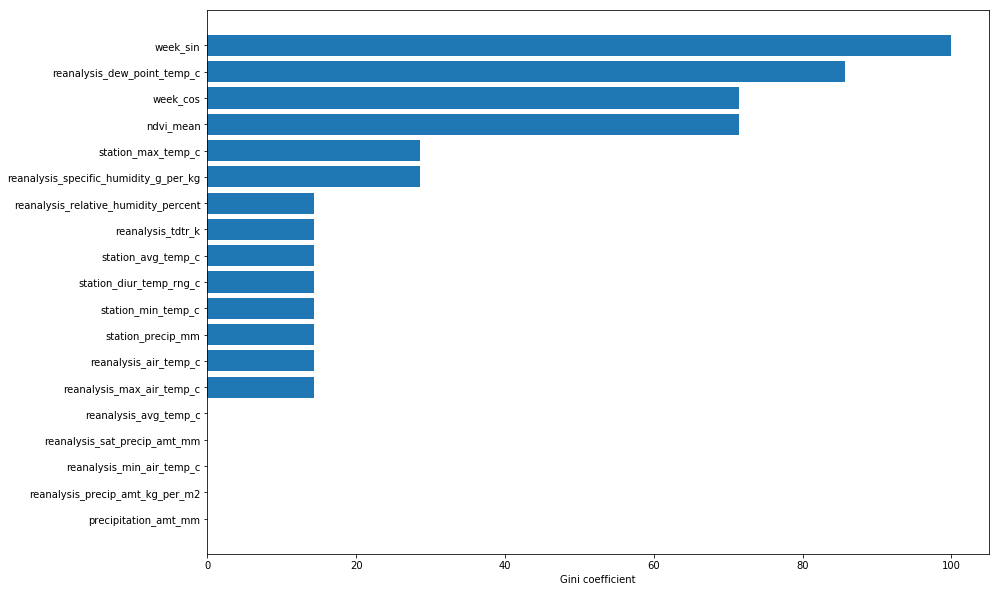

In [56]:
sj_features = renderFeatureImportance( optm_sj_xg_reg, X_train.columns )

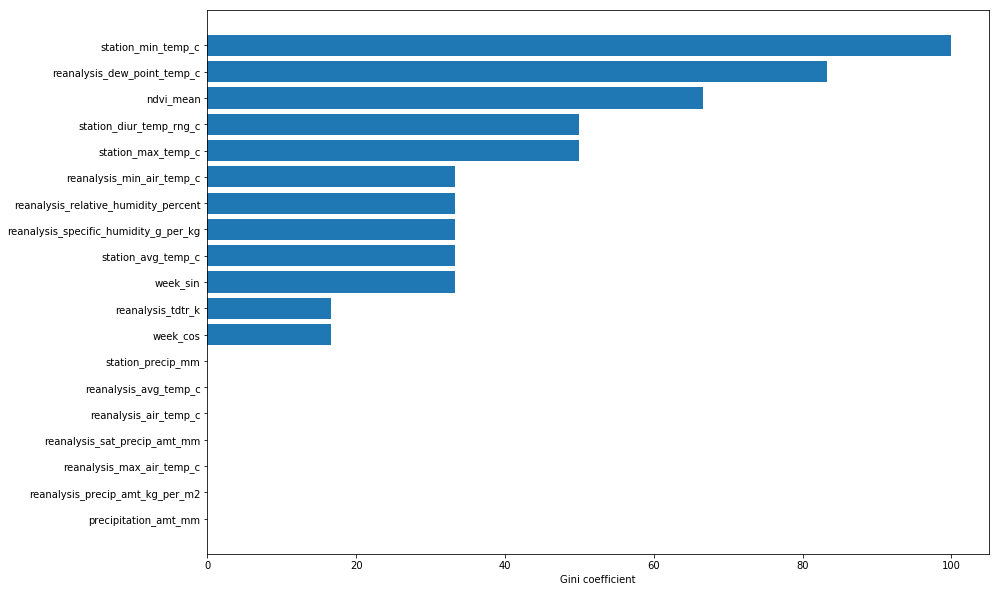

In [57]:
iq_features = renderFeatureImportance( optm_iq_xg_reg, X_train.columns )

In [58]:
%%time
sj_important_features = sj_features[sj_features.value > 0].index.tolist()
X = df_train_sj_inter[sj_important_features]
y = df_train_sj_inter[['total_cases']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=63)

optm_sj_xg_reg.fit(X_train,y_train)
y_predict = correct_prediction(optm_sj_xg_reg.predict(X_test))

regression_model_mae = mean_absolute_error(y_predict, y_test)
print('sj 3rd training - Grid Search - less features (MAE): ' + str(regression_model_mae) + '\n')

sj 3rd training - Grid Search - less features (MAE): 20.060498220640568

CPU times: user 11.2 ms, sys: 2.13 ms, total: 13.3 ms
Wall time: 16.8 ms


TODO:
- Add cycle features and remove year and weekofyear
- Test regression with presented data
- Chose most relevant features
- Time Series those features
- Predict total_cases
- Validate model performance